   
# **Dataset Overview**
**File naming convention:**
Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4).  
These identifiers define the stimulus characteristics:   
    
- **Modality** (01 = full-AV, 02 = video-only, 03 = audio-only).  
- **Vocal channel** (01 = speech, 02 = song).  
- **Emotion** (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).  
- **Emotional intensity** (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.  
- **Statement** (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").  
- **Repetition** (01 = 1st repetition, 02 = 2nd repetition).  
- **Actor** (01 to 24. Odd numbered actors are male, even numbered actors are female).  

Filename example: 02-01-06-01-02-01-12.mp4

- Video-only (**02**)  
- Speech (**01**)  
- Fearful (**06**)  
- Normal intensity (**01**)  
- Statement "dogs" (**02**)  
- 1st Repetition (**01**)  
- 12th Actor (**12**)
  
Female, as the actor ID number is even

### **Data Labels**
- **01 = neutral**
- **02 = calm**
- **03 = happy**
- **04 = sad**
- **05 = angry**
- **06 = fearful**
- **07 = disgust**
- **08 = surprised**


#### Objective
 The objective of this notebook is to perform emotion classification based on audio files.



### Importing Necessary Libraries for Audio Data Analysis and Classification

In [2]:
# Import necessary libraries for linear algebra, data processing, and CSV file I/O
import numpy as np
import pandas as pd

# Import libraries for file handling and visualization
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Import librosa for audio processing
import librosa
import librosa.display

# Import TensorFlow for building and training neural networks
import tensorflow as tf

# Import scikit-learn for preprocessing, model selection, and evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Import TensorFlow Keras modules for building a Convolutional Neural Network (CNN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Import CSV module for handling CSV file operations
import csv

# Import skimage for image processing (resizing in this case)
from skimage.transform import resize

from keras.models import load_model
import pickle

### Traversing and Printing File Paths in the RAVDESS Dataset

In [3]:
# Directory traversal to print all file paths in the 'data' directory
for dirname, _, filenames in os.walk('/kaggle/input/emotion-classification-speach'):
    # Loop through each file in the directory
    for filename in filenames:
        # Construct the full file path
        file_path = os.path.join(dirname, filename)
        # Print the file path
        print(file_path)

/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01-08-01-01-01-02.wav
/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01-01-01-01-01-02.wav
/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01-07-02-01-02-02.wav
/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01-07-01-01-02-02.wav
/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01-01-01-02-01-02.wav
/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01-06-02-02-01-02.wav
/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01-04-01-02-01-02.wav
/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01-01-01-01-02-02.wav
/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01-02-01-01-02-02.wav
/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01-03-01-01-01-02.wav
/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01-07-01-02-02-02.wav
/kaggle/input/emotion-classification-speach/speech/Actor_02/03-01

### Extracting and Saving Audio File Information from RAVDESS Dataset

The objective of this script is to extract detailed information from the filenames of the RAVDESS dataset and save it into a structured CSV file. This process facilitates the organization and analysis of the audio files by breaking down the filename into its constituent parts, such as modality, vocal channel, emotion, emotional intensity, statement, repetition, actor, and gender. By doing so, we can easily utilize this structured data for various tasks, such as emotion classification, statistical analysis, and visualization.

In [4]:
# Function to extract information from the filename
def extract_info(filename):
    # Split the filename to extract different parts
    parts = filename.split('.')[0].split('-')
    info = {
        'Modality': parts[0],
        'Vocal Channel': parts[1],
        'Emotion': parts[2],
        'Emotional Intensity': parts[3],
        'Statement': parts[4],
        'Repetition': parts[5],
        'Actor': parts[6],
    }
    return info

# Directory containing the RAVDESS files
directory = '/kaggle/input/emotion-classification-speach'

# Create a CSV file to store the extracted information
csv_file = 'audio_info.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row in the CSV file
    writer.writerow(['Filename', 'Modality', 'Vocal Channel', 'Emotion', 'Emotional Intensity', 'Statement', 'Repetition', 'Actor', 'Gender'])

    # Traverse through the directory and its subdirectories
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.wav'):
                # Construct the full file path
                filepath = os.path.join(dirname, filename)
                # Extract information from the filename
                info = extract_info(filename)
                
                # Map numerical codes to their respective labels
                modality = 'Full-AV' if info['Modality'] == '01' else 'Video-Only' if info['Modality'] == '02' else 'Audio-Only'
                vocal_channel = 'Speech' if info['Vocal Channel'] == '01' else 'Song'
                emotion_dict = {
                    '01': 'Neutral',
                    '02': 'Calm',
                    '03': 'Happy',
                    '04': 'Sad',
                    '05': 'Angry',
                    '06': 'Fearful',
                    '07': 'Disgust',
                    '08': 'Surprised'
                }
                emotion = emotion_dict[info['Emotion']]
                intensity = 'Normal' if info['Emotional Intensity'] == '01' else 'Strong'
                statement = 'Kids are talking by the door' if info['Statement'] == '01' else 'Dogs are sitting by the door'
                repetition = '1st' if info['Repetition'] == '01' else '2nd'
                actor = info['Actor']
                gender = 'Male' if int(actor) % 2 != 0 else 'Female'

                # Write the extracted information to the CSV file
                writer.writerow([filepath, modality, vocal_channel, emotion, intensity, statement, repetition, actor, gender])

# Print a success message
print(f'CSV file "{csv_file}" has been created successfully.')


CSV file "audio_info.csv" has been created successfully.


Loading and Displaying Initial Data from CSV File into a DataFrame

In [5]:
# Load the CSV file into a DataFrame
df = pd.read_csv('audio_info.csv')

# Display the first few rows of the DataFrame
df.head()

,Filename,Modality,Vocal Channel,Emotion,Emotional Intensity,Statement,Repetition,Actor,Gender
0,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,Surprised,Normal,Kids are talking by the door,1st,2,Female
1,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,Neutral,Normal,Kids are talking by the door,1st,2,Female
2,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,Disgust,Strong,Kids are talking by the door,2nd,2,Female
3,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,Disgust,Normal,Kids are talking by the door,2nd,2,Female
4,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,Neutral,Normal,Dogs are sitting by the door,1st,2,Female


#### Plotting Emotion Distribution

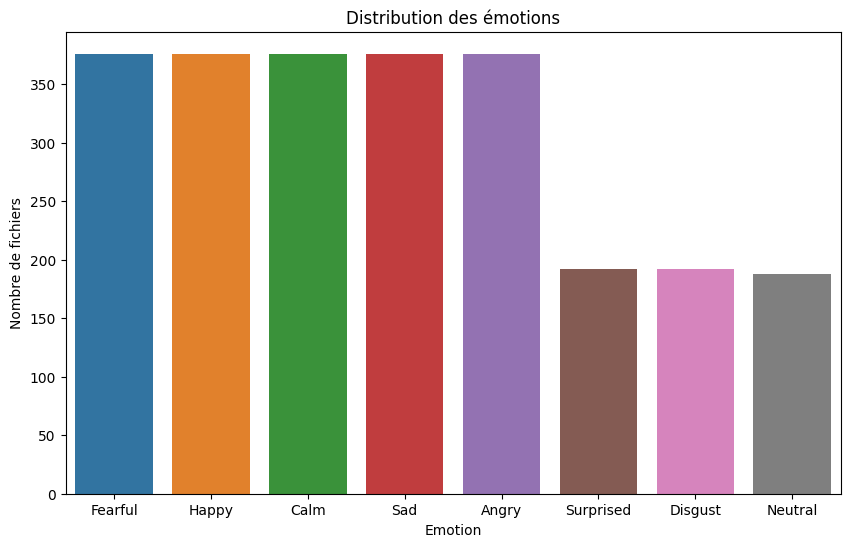

In [6]:
# Count the number of files for each emotion
emotion_counts = df['Emotion'].value_counts()

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Distribution des émotions')
plt.xlabel('Emotion')
plt.ylabel('Nombre de fichiers')
plt.show()


['Surprised' 'Neutral' 'Disgust' 'Fearful' 'Sad' 'Calm' 'Happy' 'Angry']


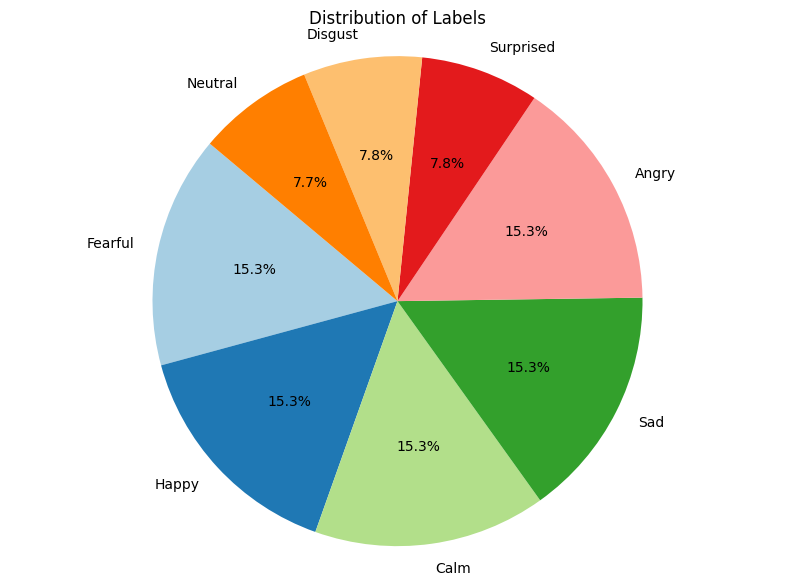

In [7]:
labels = df['Emotion'].unique()
print(labels)
label_counts = df['Emotion'].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Labels')
plt.axis('equal')
plt.show()

#### Plotting Gender Distribution

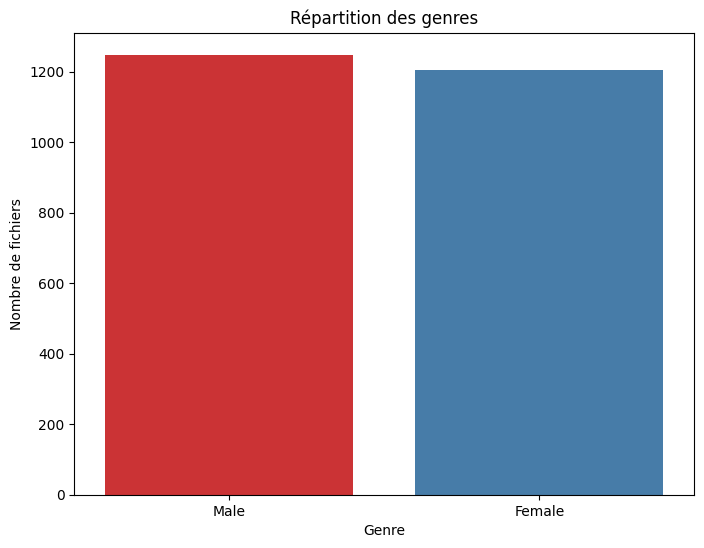

In [8]:
# Count the number of files for each gender
gender_counts = df['Gender'].value_counts()

# Plot the gender distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='Set1')
plt.title('Répartition des genres')
plt.xlabel('Genre')
plt.ylabel('Nombre de fichiers')
plt.show()

#### Checking for Missing Values in the DataFrame

In [9]:
# Check for missing values
print(df.isnull().sum())

Filename               0
Modality               0
Vocal Channel          0
Emotion                0
Emotional Intensity    0
Statement              0
Repetition             0
Actor                  0
Gender                 0
dtype: int64


#### Encoding Categorical Variables Using LabelEncoder

transform categorical variables into numerical values that can be used in machine learning models. Specifically, we will encode the 'Emotion' and 'Gender' columns in our DataFrame. Encoding categorical variables is a necessary step in preparing data for machine learning, as most algorithms require numerical input.

In [10]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the emotions
df['Emotion'] = label_encoder.fit_transform(df['Emotion'])


In [11]:
# Display the first few rows of the DataFrame
df.head()

,Filename,Modality,Vocal Channel,Emotion,Emotional Intensity,Statement,Repetition,Actor,Gender
0,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,7,Normal,Kids are talking by the door,1st,2,Female
1,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,5,Normal,Kids are talking by the door,1st,2,Female
2,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,2,Strong,Kids are talking by the door,2nd,2,Female
3,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,2,Normal,Kids are talking by the door,2nd,2,Female
4,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,5,Normal,Dogs are sitting by the door,1st,2,Female


#### Function to Plot the Waveform of an Audio File

randomly select a sample of audio files from the dataset and display their waveforms in a grid layout with three columns. This visualization helps in quickly inspecting multiple audio files, providing insights into their waveforms, emotions, genders, and other attributes.

In [12]:
# Function to display the waveform of an audio file
def plot_waveform(ax, filepath, title):
    data, sampling_rate = librosa.load(filepath, sr=None)
    librosa.display.waveshow(data, sr=sampling_rate, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Amplitude')

#### Displaying Random Audio File Waveforms in a Grid

randomly select a sample of audio files from the dataset and display their waveforms in a grid layout with three columns. This visualization helps in quickly inspecting multiple audio files, providing insights into their waveforms, emotions, genders, and other attributes.

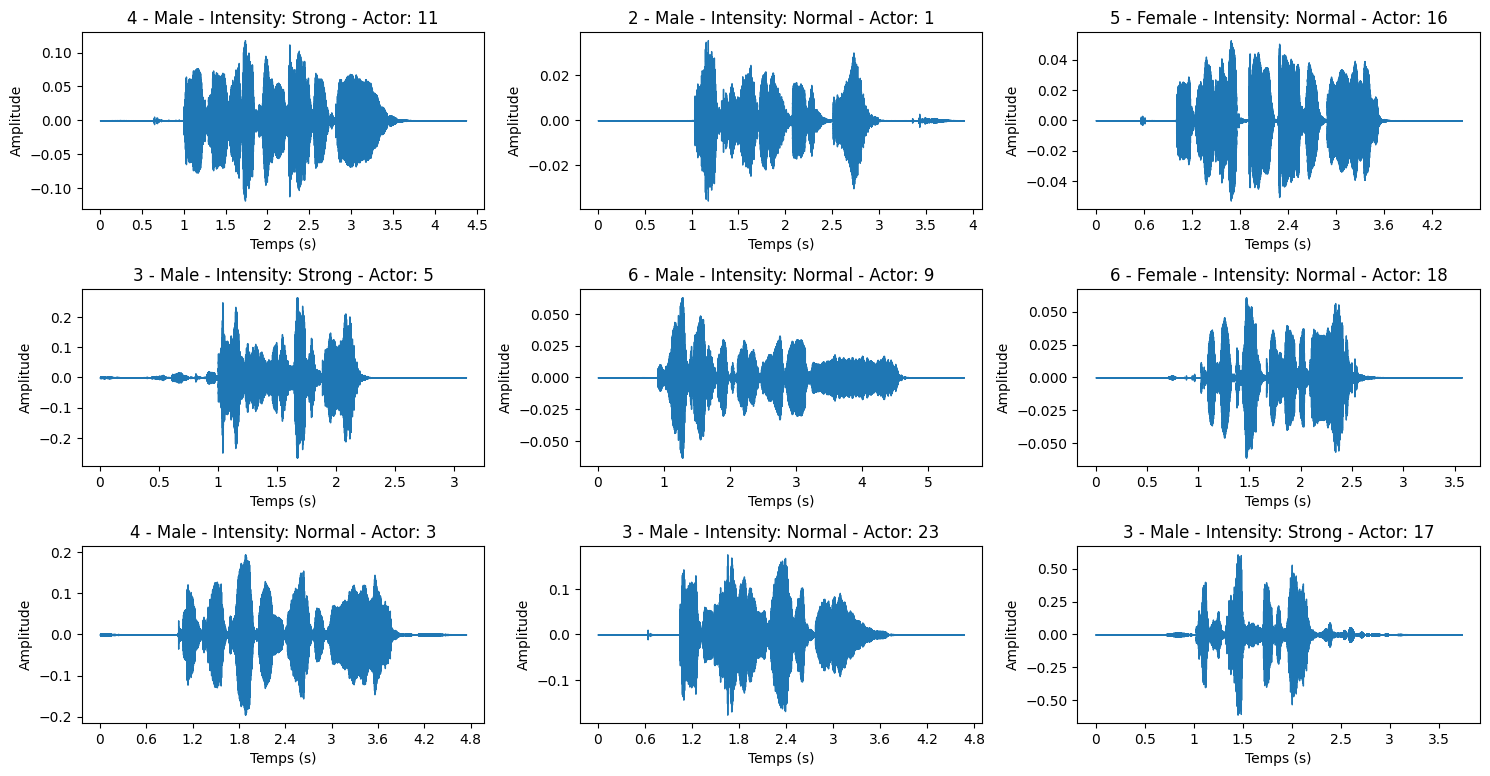

In [13]:
# Maximum number of files to display
max_files = 9

# Get a random sample of audio files
audio_files = df.sample(n=max_files)

# Create a grid of subplots with 3 columns
fig, axes = plt.subplots(nrows=(max_files // 3) + 1, ncols=3, figsize=(15, 10))

# Flatten the axes for easy access
axes = axes.flatten()

for idx, (i, row) in enumerate(audio_files.iterrows()):
    plot_waveform(axes[idx], row['Filename'], f"{row['Emotion']} - {row['Gender']} - Intensity: {row['Emotional Intensity']} - Actor: {row['Actor']}")

# Remove unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Function to Convert Audio to Spectrogram

convert an audio file into a spectrogram representation. A spectrogram provides a visual representation of the spectrum of frequencies in a sound signal as it varies with time. This transformation is useful for audio analysis, feature extraction, and machine learning tasks involving audio data.

In [14]:
def audio_to_spectrogram(filepath, n_fft=2048, hop_length=512):
    # Charger le fichier audio
    y, sr = librosa.load(filepath, sr=None)
    # Convertir l'audio en un spectrogramme
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Convertir en échelle logarithmique
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB, sr


#### Function to Plot Spectrogram of an Audio File

In [15]:
def plot_spectrogram(ax, filepath, title, sr):
    S_dB, _ = audio_to_spectrogram(filepath)
    img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(title)
    ax.label_outer()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return img


#### Displaying Random Audio Spectrograms in a Grid

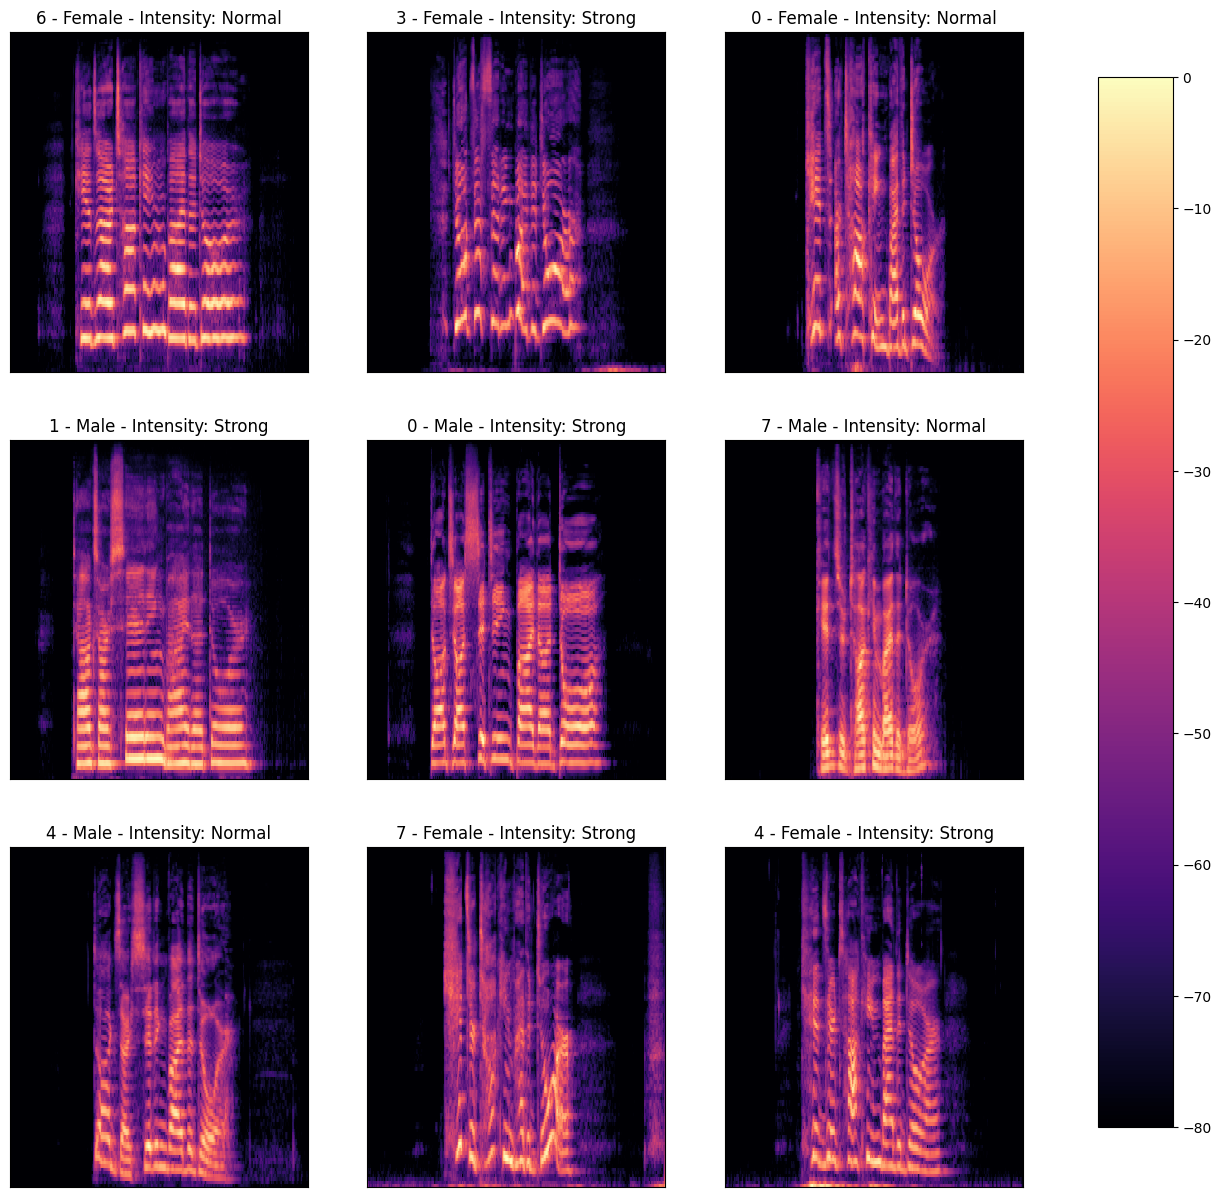

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the DataFrame 'df' is already loaded
# Maximum number of files to display
max_files = 9

# Randomly select 9 audio files
random_files = df.sample(n=max_files, random_state=42)  # Adjust the random_state column for reproducibility

# Create a grid of subplots with 3 columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Flatten the axes for easy access
axes = axes.flatten()

# Display the spectrograms
for idx, (i, row) in enumerate(random_files.iterrows()):
    img = plot_spectrogram(axes[idx], row['Filename'], f"{row['Emotion']} - {row['Gender']} - Intensity: {row['Emotional Intensity']}", sr=22050)

# Remove unused subplots (if any)
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Add the colorbar
fig.subplots_adjust(right=0.8)  # Adjust the subplot layout to make room for the colorbar
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])  # Add an axes for the colorbar
fig.colorbar(img, cax=cbar_ax)  # Create the colorbar in the new axes

plt.show()

# Spectograms 

In the following section, we will train a model for emotion classification using spectrograms. This part of the notebook focuses on preparing the data, defining the model architecture, and training the model to accurately classify emotions based on audio features represented as spectrograms.

#### Preparing Data for Spectrogram-Based Analysis

prepare the data by converting audio files into spectrograms, resizing them to a specified image size, and organizing the data into feature (X) and target (y) arrays. This preprocessing step is crucial for training machine learning models, especially for tasks like audio classification where spectrograms are used as input features.

In [17]:
def audio_to_spectrogram_array(filepath, n_fft=2048, hop_length=512):
    # Load the audio file
    y, sr = librosa.load(filepath, sr=None)
    # Convert the audio to a spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Convert to log scale
    S_dB = librosa.power_to_db(S, ref=np.max)
    return np.array(S_dB)  # Ensure it's a NumPy array


def prepare_data(df, img_height, img_width):
    X = []
    y = []
    for idx, row in df.iterrows():
        spectrogram = audio_to_spectrogram_array(row['Filename'])
        spectrogram_resized = resize(spectrogram, (img_height, img_width), mode='constant', anti_aliasing=True)
        X.append(spectrogram_resized)
        y.append(row['Emotion'])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [18]:
# Resizing parameters
img_height = 128
img_width = 128

# Prepare the data
X, y = prepare_data(df, img_height, img_width)

#### Splitting Data and Preparing for Convolutional Neural Networks (CNNs)

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a channel dimension for CNN
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

 #### Creating and Compiling a Convolutional Neural Network (CNN) Model

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input

# Check if GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available, using CPU instead.")

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Input layer
        Input(shape=input_shape),
        
        # Convolutional Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Convolutional Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Convolutional Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Convolutional Block 4 (Optional for deeper networks)
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Global Average Pooling
        GlobalAveragePooling2D(),
        
        # Fully Connected Layers
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
input_shape = (img_height, img_width, 1)  # Adjust according to your data
num_classes = len(df['Emotion'].unique())  # Assuming df is your DataFrame
model_simple = create_cnn_model(input_shape, num_classes)

# Compile the model
model_simple.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_simple.summary()

1 Physical GPUs, 1 Logical GPUs


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,480 (1.87 MB)

 Trainable params: 488,520 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

#### Training the Convolutional Neural Network (CNN) Model

In [21]:
# Train the model
history_simple = model_simple.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2)

Epoch 1/60


2024-07-25 15:26:03.905864: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.8165, expected 1.15449
2024-07-25 15:26:03.905939: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.77157, expected 2.10956
2024-07-25 15:26:03.905948: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.76453, expected 2.10252
2024-07-25 15:26:03.905956: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.46159, expected 1.79958
2024-07-25 15:26:03.905964: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.11856, expected 1.45655
2024-07-25 15:26:03.905972: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.42696, expected 1.76495
2024-07-25 15:26:03.905979: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.20123, expected 1.53922
2024-07-25 15:26:03.905987: E external/local_xla/xla/ser

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1241 - loss: 2.2441

I0000 00:00:1721921168.832308   50161 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1440 - loss: 2.1424

2024-07-25 15:26:10.306156: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.24102, expected 1.00489
2024-07-25 15:26:10.306218: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 1.08293, expected 0.846799
2024-07-25 15:26:10.306228: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 0.961029, expected 0.7249
2024-07-25 15:26:10.306236: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 1.25938, expected 1.02325
2024-07-25 15:26:10.306244: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 1.20885, expected 0.972717
2024-07-25 15:26:10.306253: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 0.674338, expected 0.438209
2024-07-25 15:26:10.306266: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 41: 1.27763, expected 1.0415
2024-07-25 15:26:10.306274: E external/local_xla

49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.1476 - loss: 2.1326 - val_accuracy: 0.1476 - val_loss: 8.0090
Epoch 2/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2817 - loss: 1.8069 - val_accuracy: 0.1628 - val_loss: 9.8967
Epoch 3/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2755 - loss: 1.7731 - val_accuracy: 0.1959 - val_loss: 3.0529
Epoch 4/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3825 - loss: 1.6327 - val_accuracy: 0.0891 - val_loss: 3.3851
Epoch 5/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3651 - loss: 1.6133 - val_accuracy: 0.0738 - val_loss: 8.1940
Epoch 6/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4108 - loss: 1.4491 - val_accuracy: 0.2417 - val_loss: 2.6495
Epoch 7/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4192 - loss: 1.4637 - val_accuracy: 0.1705 - val_loss: 5.8362
Epoch 8/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4728 - loss: 1.3708 - val_accuracy: 0.2468 - val_loss: 2

### **Metrics**

 1/16 ━━━━━━━━━━━━━━━━━━━━ 7s 482ms/step

2024-07-25 15:27:36.064182: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.93675, expected 1.04895
2024-07-25 15:27:36.064235: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.61817, expected 1.73038
2024-07-25 15:27:36.064245: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.53313, expected 1.64533
2024-07-25 15:27:36.064253: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.56878, expected 1.68098
2024-07-25 15:27:36.064260: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.13868, expected 1.25088
2024-07-25 15:27:36.064268: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.80534, expected 0.91755
2024-07-25 15:27:36.064276: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.78962, expected 0.901827
2024-07-25 15:27:36.064284: E external/local_xla/xla/s

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


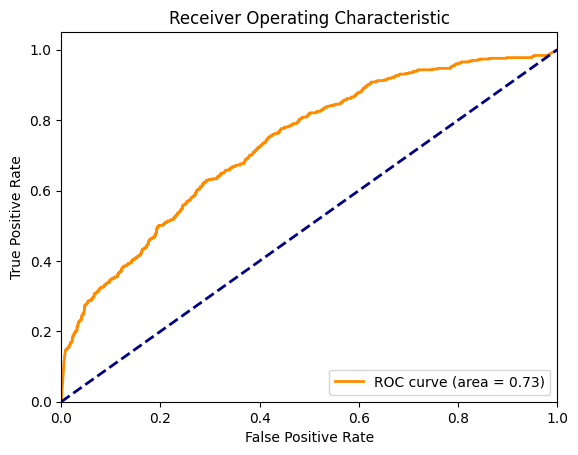

Accuracy: 0.34
Precision: 0.72
Recall: 0.34
F1-score: 0.28
AUC: 0.73


In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Make predictions on the test set
y_pred = model_simple.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# AUC and ROC
y_test_bin = to_categorical(y_test, num_classes)
y_pred_prob = y_pred  # Model's output probabilities

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC: {roc_auc["micro"]:.2f}')

### **Confusion Matrix**

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


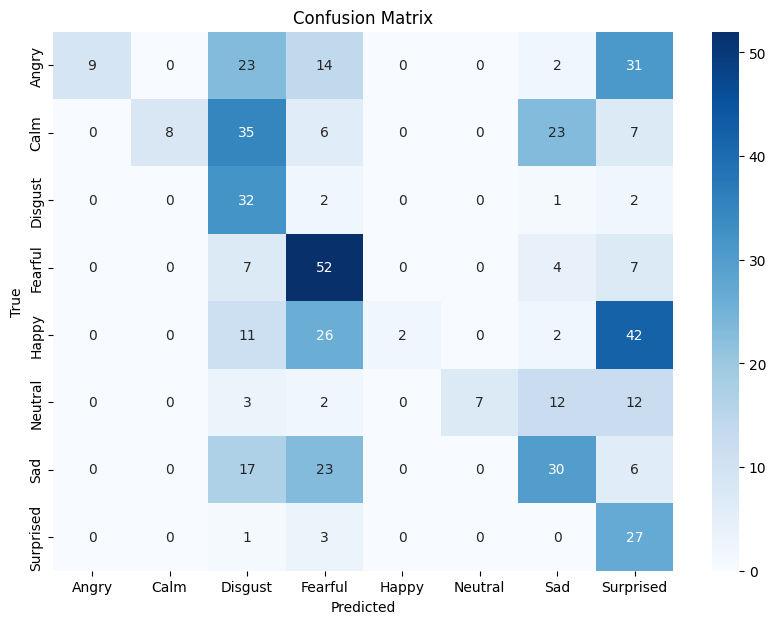

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = model_simple.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### **Saving the model**

In [24]:
from keras.models import load_model

# Saving the model
model_simple.save('model_simple.h5')

## Data Augmentation for Audio Files

we will apply data augmentation techniques to our audio files to retrain the model. The goal of data augmentation is to increase the accuracy and improve the metric values obtained after training the model without augmentation. By artificially expanding our training dataset with variations such as adding noise, and pitch shifting, we aim to make our model more robust and capable of generalizing better to unseen data.

#### Objective of Data Augmentation for Emotion Classification

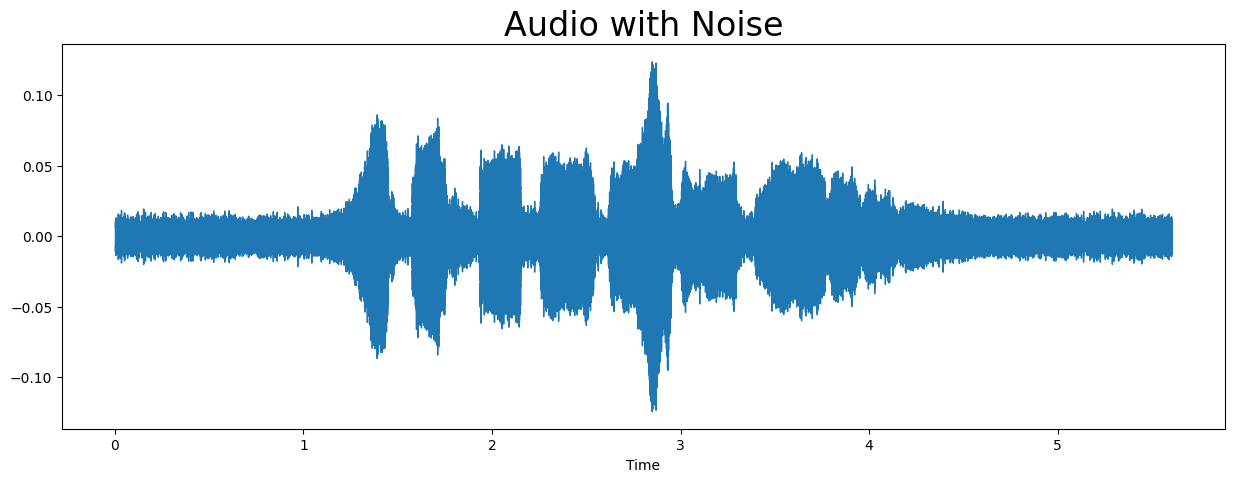

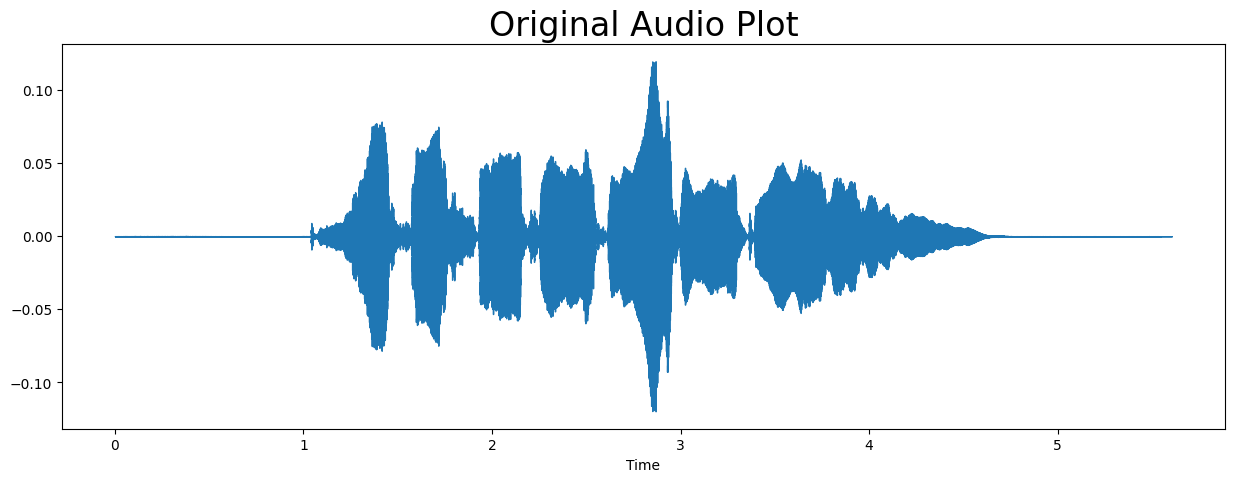

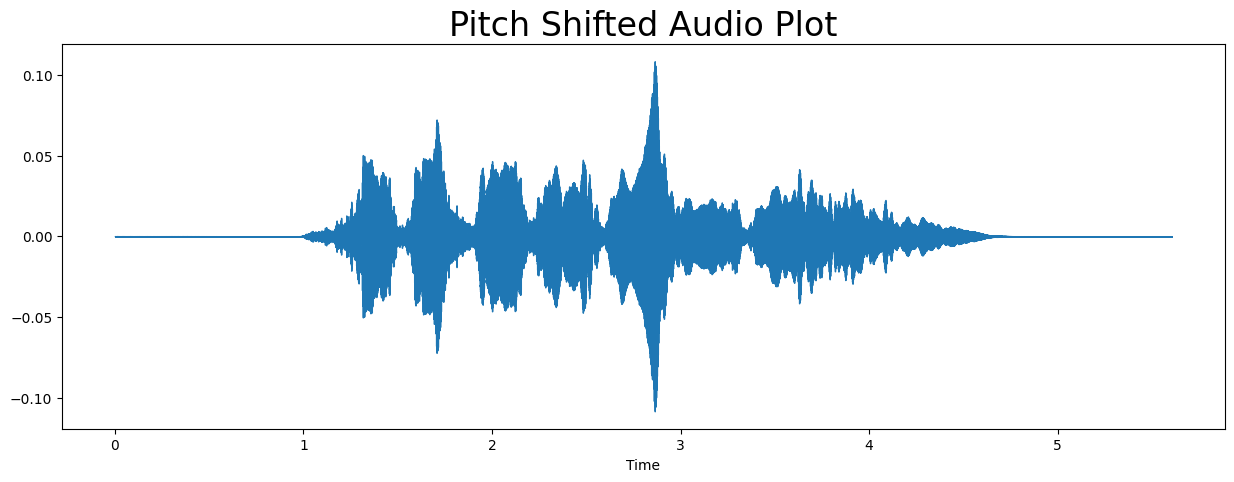

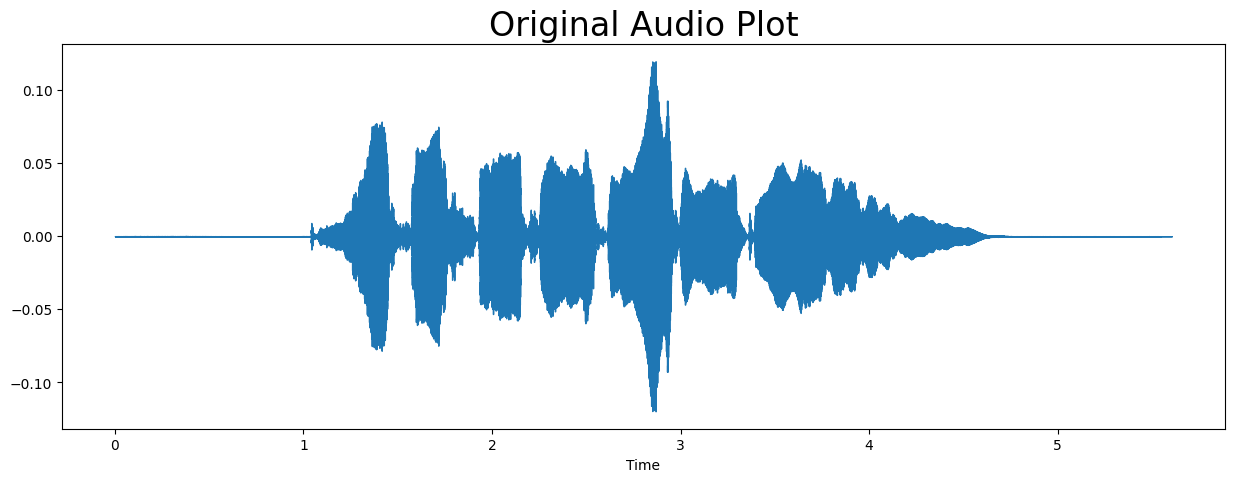

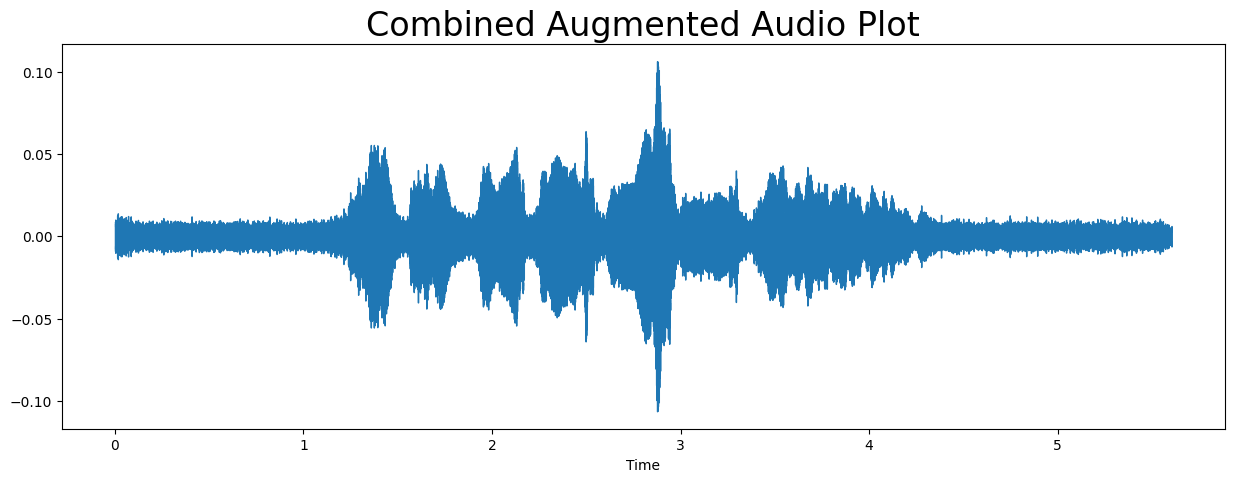

In [25]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

def noise(data, noise_level=0.005):
    """ Adds noise to the audio """
    noise = np.random.randn(len(data))
    data_noise = data + noise_level * noise
    return data_noise

def pitch(data, sr, n_steps=4):
    """ Changes the pitch of the audio signal """
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# Load the audio data
file_path = '/kaggle/input/emotion-classification-speach/song/Actor_02/03-02-02-01-02-02-02.wav'
data, sampling_rate = librosa.load(file_path)

# Add noise
data_noise = noise(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data_noise, sr=sampling_rate)
plt.title('Audio with Noise', size=24)
plt.show()
ipd.display(ipd.Audio(data_noise, rate=sampling_rate))

# Pitch shifting
data_pitch = pitch(data, sr=sampling_rate)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title('Original Audio Plot', size=24)
plt.show()
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data_pitch, sr=sampling_rate)
plt.title('Pitch Shifted Audio Plot', size=24)
plt.show()
ipd.display(ipd.Audio(data_pitch, rate=sampling_rate))

# Combination of all augmentations
data_combined = pitch(noise(data), sr=sampling_rate)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title('Original Audio Plot', size=24)
plt.show()
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data_combined, sr=sampling_rate)
plt.title('Combined Augmented Audio Plot', size=24)
plt.show()
ipd.display(ipd.Audio(data_combined, rate=sampling_rate))


#### Saving Augmented Audio Files

In [26]:
import os
import soundfile as sf  # Library for saving audio files

# Directory to save the augmented audio files
output_dir = 'augmented_data'
os.makedirs(output_dir, exist_ok=True)

# Iterate through the directory and apply augmentations
for dirname, _, filenames in os.walk('/kaggle/input/emotion-classification-speach'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        try:
            # Load the audio data
            data, sampling_rate = librosa.load(file_path)

            # Apply augmentations
            data_noise = noise(data)
            data_pitch = pitch(data, sr=sampling_rate)
            data_combined = pitch(noise(data), sr=sampling_rate)

            # Construct output paths for the augmented files
            base_name, ext = os.path.splitext(filename)
            output_path_original = os.path.join(output_dir, f"{base_name}-original{ext}")
            output_path_noise = os.path.join(output_dir, f"{base_name}-noise{ext}")
            output_path_pitch = os.path.join(output_dir, f"{base_name}-pitch{ext}")
            output_path_combined = os.path.join(output_dir, f"{base_name}-combined{ext}")

            # Save the audio files
            sf.write(output_path_original, data, sampling_rate)
            sf.write(output_path_noise, data_noise, sampling_rate)
            sf.write(output_path_pitch, data_pitch, sampling_rate)
            sf.write(output_path_combined, data_combined, sampling_rate)

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")


#### Extracting and Saving Audio File Information

In [27]:
# Function to extract information from the filename
def extract_info(filename):
    # Split the filename to extract different parts
    parts = filename.split('.')[0].split('-')
    info = {
        'Modality': parts[0],
        'Vocal Channel': parts[1],
        'Emotion': parts[2],
        'Emotional Intensity': parts[3],
        'Statement': parts[4],
        'Repetition': parts[5],
        'Actor': parts[6],
    }
    return info

# Directory containing the RAVDESS files
directory = 'augmented_data'

# Create a CSV file to store the extracted information
csv_file = 'audio_info_augmented_data.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row in the CSV file
    writer.writerow(['Filename', 'Modality', 'Vocal Channel', 'Emotion', 'Emotional Intensity', 'Statement', 'Repetition', 'Actor', 'Gender'])

    # Traverse through the directory and its subdirectories
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.wav'):
                # Construct the full file path
                filepath = os.path.join(dirname, filename)
                # Extract information from the filename
                info = extract_info(filename)
                
                # Map numerical codes to their respective labels
                modality = 'Full-AV' if info['Modality'] == '01' else 'Video-Only' if info['Modality'] == '02' else 'Audio-Only'
                vocal_channel = 'Speech' if info['Vocal Channel'] == '01' else 'Song'
                emotion_dict = {
                    '01': 'Neutral',
                    '02': 'Calm',
                    '03': 'Happy',
                    '04': 'Sad',
                    '05': 'Angry',
                    '06': 'Fearful',
                    '07': 'Disgust',
                    '08': 'Surprised'
                }
                emotion = emotion_dict[info['Emotion']]
                intensity = 'Normal' if info['Emotional Intensity'] == '01' else 'Strong'
                statement = 'Kids are talking by the door' if info['Statement'] == '01' else 'Dogs are sitting by the door'
                repetition = '1st' if info['Repetition'] == '01' else '2nd'
                actor = info['Actor']
                gender = 'Male' if int(actor) % 2 != 0 else 'Female'

                # Write the extracted information to the CSV file
                writer.writerow([filepath, modality, vocal_channel, emotion, intensity, statement, repetition, actor, gender])

In [28]:
# Load the CSV file into a DataFrame
df_augmented = pd.read_csv('audio_info_augmented_data.csv')

print(df_augmented.shape)

# Display the first few rows of the DataFrame
df_augmented.head()

(9808, 19)


,Filename,Modality,Vocal Channel,Emotion,Emotional Intensity,Statement,Repetition,Actor,Gender,mfccs_mean,chroma_stft_mean,mel_spectrogram_mean,spectral_centroid_mean,spectral_bandwidth_mean,spectral_contrast_mean,spectral_rolloff_mean,zero_crossing_rate_mean,rmse_mean,pitches_mean
0,/kaggle/working/augmented_data/03-01-07-01-02-...,Audio-Only,Speech,Disgust,Normal,Dogs are sitting by the door,2nd,13,Male,"[-728.4608, 64.43513, 6.500011, 10.830953, -0....","[0.59143835, 0.62324, 0.65548474, 0.6012447, 0...","[1.2719e-05, 5.9448544e-06, 2.807378e-05, 0.00...",[3402.54310919],[2824.66362676],"[20.304918447455005, 12.874192430482175, 14.53...",[6645.06958008],[0.16507394],[0.00140201],1114.3989
1,/kaggle/working/augmented_data/03-02-06-01-02-...,Audio-Only,Song,Fearful,Normal,Dogs are sitting by the door,2nd,23,Male,"[-489.75394, 53.394203, -15.177028, 6.0070934,...","[0.3476454, 0.28526214, 0.3060718, 0.44392413,...","[7.5881515e-05, 9.613191e-05, 0.000115843606, ...",[3127.75767373],[2588.84722501],"[24.71635350853244, 17.563434398100622, 19.276...",[5743.3423335],[0.27023708],[0.01671837],1577.7954
2,/kaggle/working/augmented_data/03-01-05-02-01-...,Audio-Only,Speech,Angry,Strong,Kids are talking by the door,1st,23,Male,"[-456.337, 21.949965, -20.253494, -1.9425161, ...","[0.48397905, 0.4799635, 0.47601542, 0.5007777,...","[0.009674967, 0.0039264695, 0.0014892255, 0.00...",[3500.68517167],[2824.44556766],"[16.439919762660168, 16.289028184616296, 17.65...",[6789.69726562],[0.20953577],[0.02529958],1504.7352
3,/kaggle/working/augmented_data/03-01-08-01-01-...,Audio-Only,Speech,Surprised,Normal,Kids are talking by the door,1st,17,Male,"[-560.1946, 43.547802, -1.8486894, 7.7822824, ...","[0.5739701, 0.61637896, 0.5792289, 0.5594958, ...","[0.043927442, 0.0009773717, 0.0017048344, 0.02...",[3099.86027156],[3016.95491528],"[19.49225785633489, 13.681661111913282, 15.649...",[6687.37792969],[0.17385138],[0.00858038],1674.1929
4,/kaggle/working/augmented_data/03-01-08-02-01-...,Audio-Only,Speech,Surprised,Strong,Kids are talking by the door,1st,17,Male,"[-285.92004, 13.031654, 4.2276635, 5.8913064, ...","[0.6008465, 0.65691036, 0.69855917, 0.7119562,...","[0.31914127, 0.012662421, 0.0035561817, 0.0040...",[4720.47988621],[3197.50888107],"[14.520101658424988, 13.165214300387674, 13.65...",[8690.96966912],[0.35532514],[0.01594769],2029.0355


In [29]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the emotions
df_augmented['Emotion'] = label_encoder.fit_transform(df_augmented['Emotion'])

In [30]:
print(df_augmented.shape)

# Display the first few rows of the DataFrame
df_augmented.head()

(9808, 19)


,Filename,Modality,Vocal Channel,Emotion,Emotional Intensity,Statement,Repetition,Actor,Gender,mfccs_mean,chroma_stft_mean,mel_spectrogram_mean,spectral_centroid_mean,spectral_bandwidth_mean,spectral_contrast_mean,spectral_rolloff_mean,zero_crossing_rate_mean,rmse_mean,pitches_mean
0,/kaggle/working/augmented_data/03-01-07-01-02-...,Audio-Only,Speech,2,Normal,Dogs are sitting by the door,2nd,13,Male,"[-728.4608, 64.43513, 6.500011, 10.830953, -0....","[0.59143835, 0.62324, 0.65548474, 0.6012447, 0...","[1.2719e-05, 5.9448544e-06, 2.807378e-05, 0.00...",[3402.54310919],[2824.66362676],"[20.304918447455005, 12.874192430482175, 14.53...",[6645.06958008],[0.16507394],[0.00140201],1114.3989
1,/kaggle/working/augmented_data/03-02-06-01-02-...,Audio-Only,Song,3,Normal,Dogs are sitting by the door,2nd,23,Male,"[-489.75394, 53.394203, -15.177028, 6.0070934,...","[0.3476454, 0.28526214, 0.3060718, 0.44392413,...","[7.5881515e-05, 9.613191e-05, 0.000115843606, ...",[3127.75767373],[2588.84722501],"[24.71635350853244, 17.563434398100622, 19.276...",[5743.3423335],[0.27023708],[0.01671837],1577.7954
2,/kaggle/working/augmented_data/03-01-05-02-01-...,Audio-Only,Speech,0,Strong,Kids are talking by the door,1st,23,Male,"[-456.337, 21.949965, -20.253494, -1.9425161, ...","[0.48397905, 0.4799635, 0.47601542, 0.5007777,...","[0.009674967, 0.0039264695, 0.0014892255, 0.00...",[3500.68517167],[2824.44556766],"[16.439919762660168, 16.289028184616296, 17.65...",[6789.69726562],[0.20953577],[0.02529958],1504.7352
3,/kaggle/working/augmented_data/03-01-08-01-01-...,Audio-Only,Speech,7,Normal,Kids are talking by the door,1st,17,Male,"[-560.1946, 43.547802, -1.8486894, 7.7822824, ...","[0.5739701, 0.61637896, 0.5792289, 0.5594958, ...","[0.043927442, 0.0009773717, 0.0017048344, 0.02...",[3099.86027156],[3016.95491528],"[19.49225785633489, 13.681661111913282, 15.649...",[6687.37792969],[0.17385138],[0.00858038],1674.1929
4,/kaggle/working/augmented_data/03-01-08-02-01-...,Audio-Only,Speech,7,Strong,Kids are talking by the door,1st,17,Male,"[-285.92004, 13.031654, 4.2276635, 5.8913064, ...","[0.6008465, 0.65691036, 0.69855917, 0.7119562,...","[0.31914127, 0.012662421, 0.0035561817, 0.0040...",[4720.47988621],[3197.50888107],"[14.520101658424988, 13.165214300387674, 13.65...",[8690.96966912],[0.35532514],[0.01594769],2029.0355


In [31]:
# Resizing parameters
img_height = 128
img_width = 128

# Prepare the data
X, y = prepare_data(df_augmented, img_height, img_width)

#### Splitting Data and Preparing for Convolutional Neural Networks (CNNs)

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a channel dimension for CNN
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


### Next we set to use a more complex model with 2 dimensional convolutional layers

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the input shape and number of classes
input_shape = (img_height, img_width, 1)  # (height, width, channels)
num_classes = len(np.unique(y_train))  # Assuming y_train contains class labels

def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # Convolutional Block 1
    model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    
    # Convolutional Block 2
    model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Convolutional Block 3
    model.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    
    # Convolutional Block 4
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Convolutional Block 5
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=3, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Create the model
model_complex = create_cnn_model(input_shape, num_classes)

# Compile the model
model_complex.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_complex.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 256)  │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 256)    │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         2,05

 Total params: 2,954,824 (11.27 MB)

 Trainable params: 2,952,648 (11.26 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [34]:
# Train the model
history_complex = model_complex.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2)

Epoch 1/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 58s 156ms/step - accuracy: 0.2312 - loss: 2.1792 - val_accuracy: 0.1611 - val_loss: 2.4291
Epoch 2/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.3935 - loss: 1.5505 - val_accuracy: 0.2318 - val_loss: 3.1392
Epoch 3/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.4304 - loss: 1.4333 - val_accuracy: 0.2745 - val_loss: 2.2651
Epoch 4/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.4989 - loss: 1.2883 - val_accuracy: 0.3682 - val_loss: 1.6969
Epoch 5/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.5617 - loss: 1.1582 - val_accuracy: 0.6134 - val_loss: 1.0404
Epoch 6/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.6365 - loss: 0.9514 - val_accuracy: 0.3847 - val_loss: 2.4380
Epoch 7/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.6793 - loss: 0.8502 - val_accuracy: 0.5076 - val_loss: 1.4289
Epoch 8/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.6247 - loss: 1.0015 -

62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step


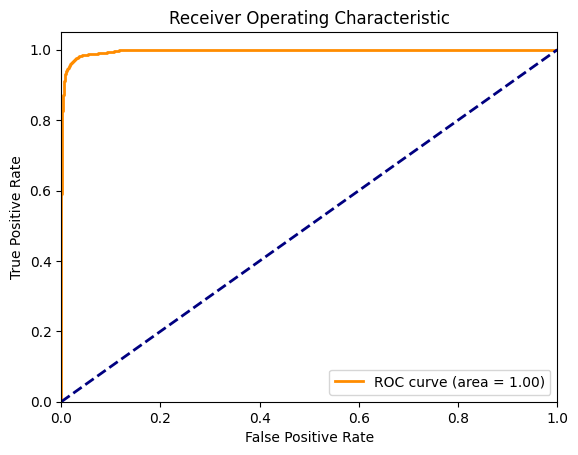

Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1-score: 0.93
AUC: 1.00


In [35]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Make predictions on the test set
y_pred = model_complex.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# AUC and ROC
y_test_bin = to_categorical(y_test, num_classes)
y_pred_prob = y_pred  # Model's output probabilities

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC: {roc_auc["micro"]:.2f}')

### **Confusion Matrix**

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


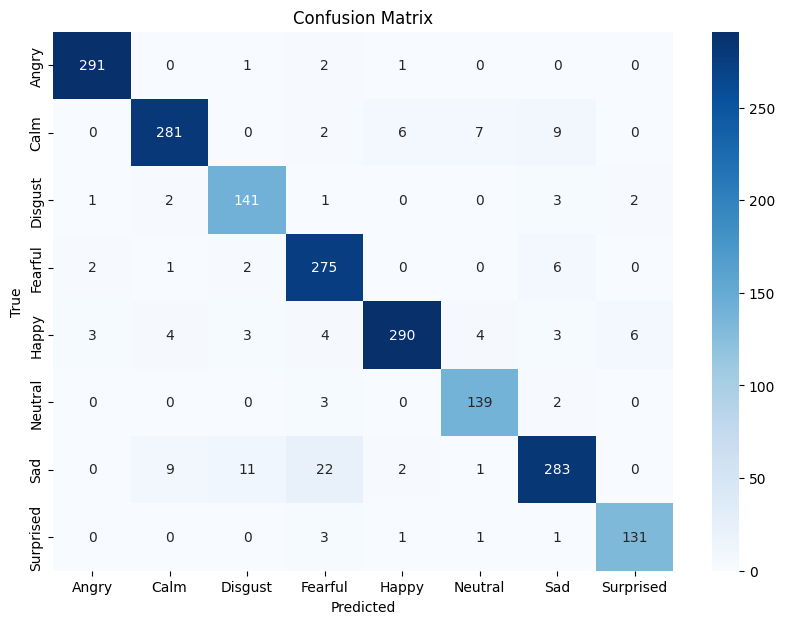

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = model_complex.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **Regularization**

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the input shape and number of classes
input_shape = (img_height, img_width, 1)  # (height, width, channels)
num_classes = len(np.unique(y_train))  # Assuming y_train contains class labels

def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # Convolutional Block 1
    model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    
    # Convolutional Block 2
    model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Convolutional Block 3
    model.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    
    # Convolutional Block 4
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Convolutional Block 5
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=3, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Create the model
model_complex = create_cnn_model(input_shape, num_classes)

# Compile the model
model_complex.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_complex.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 256)  │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 256)    │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         2,05

 Total params: 2,954,824 (11.27 MB)

 Trainable params: 2,952,648 (11.26 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15)  # probably needs to be more patient, but kaggle time is limited

callbacks_list = [early, reduceLROnPlat]

In [42]:
# Train the model
history_complex_reg = model_complex.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - accuracy: 0.2328 - loss: 2.1702 - val_accuracy: 0.1752 - val_loss: 3.2984 - learning_rate: 0.0010
Epoch 2/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.3701 - loss: 1.6277 - val_accuracy: 0.3242 - val_loss: 2.0322 - learning_rate: 0.0010
Epoch 3/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.4245 - loss: 1.4509 - val_accuracy: 0.2586 - val_loss: 2.1661 - learning_rate: 0.0010
Epoch 4/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.5082 - loss: 1.2937 - val_accuracy: 0.3013 - val_loss: 2.6077 - learning_rate: 0.0010
Epoch 5/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.5726 - loss: 1.1506 - val_accuracy: 0.4427 - val_loss: 1.4390 - learning_rate: 0.0010
Epoch 6/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.6235 - loss: 0.9936 - val_accuracy: 0.4522 - val_loss: 1.4486 - learning_rate: 0.0010
Epoch 7/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.6798 - 

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


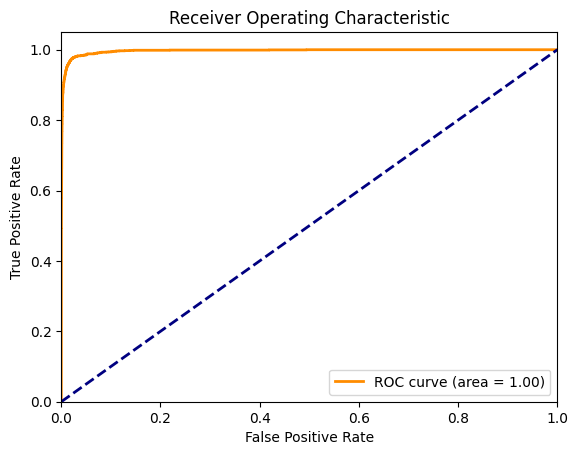

Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-score: 0.94
AUC: 1.00


In [44]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Make predictions on the test set
y_pred = model_complex.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# AUC and ROC
y_test_bin = to_categorical(y_test, num_classes)
y_pred_prob = y_pred  # Model's output probabilities

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC: {roc_auc["micro"]:.2f}')

### **Saving the model**

In [45]:
from keras.models import load_model

# Saving the model
model_complex.save('model_complex.h5')

## Extracted Features for **non augmented data**:

#### Extracting and Saving Audio File Information and Features


In [46]:
import os
import csv
import librosa
import numpy as np

# Function to extract information from the filename
def extract_info(filename):
    # Split the filename to extract different parts
    parts = filename.split('.')[0].split('-')
    info = {
        'Modality': parts[0],
        'Vocal Channel': parts[1],
        'Emotion': parts[2],
        'Emotional Intensity': parts[3],
        'Statement': parts[4],
        'Repetition': parts[5],
        'Actor': parts[6],
    }
    return info

# Function to extract audio features
def extract_audio_features(filepath):
    y, sr = librosa.load(filepath, sr=None)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
    rmse = np.mean(librosa.feature.rms(y=y).T, axis=0)
    pitches, _ = librosa.piptrack(y=y, sr=sr)
    pitches_mean = np.mean(pitches[pitches > 0])
    
    return (mfccs, chroma, mel, spectral_centroid, spectral_bandwidth, 
            spectral_contrast, spectral_rolloff, zero_crossing_rate, rmse, pitches_mean)

# Directory containing the RAVDESS files
directory = '/kaggle/input/emotion-classification-speach'

# Create a CSV file to store the extracted information
csv_file = 'audio_info_large.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row in the CSV file
    writer.writerow(['Filename', 'Modality', 'Vocal Channel', 'Emotion', 'Emotional Intensity', 'Statement', 'Repetition', 'Actor', 'Gender', 
                     'mfccs_mean', 'chroma_stft_mean', 'mel_spectrogram_mean', 'spectral_centroid_mean', 
                     'spectral_bandwidth_mean', 'spectral_contrast_mean', 'spectral_rolloff_mean', 
                     'zero_crossing_rate_mean', 'rmse_mean', 'pitches_mean'])

    # Traverse through the directory and its subdirectories
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.wav'):
                # Construct the full file path
                filepath = os.path.join(dirname, filename)
                # Extract information from the filename
                info = extract_info(filename)
                
                # Map numerical codes to their respective labels
                modality = 'Full-AV' if info['Modality'] == '01' else 'Video-Only' if info['Modality'] == '02' else 'Audio-Only'
                vocal_channel = 'Speech' if info['Vocal Channel'] == '01' else 'Song'
                emotion_dict = {
                    '01': 'Neutral',
                    '02': 'Calm',
                    '03': 'Happy',
                    '04': 'Sad',
                    '05': 'Angry',
                    '06': 'Fearful',
                    '07': 'Disgust',
                    '08': 'Surprised'
                }
                emotion = emotion_dict[info['Emotion']]
                intensity = 'Normal' if info['Emotional Intensity'] == '01' else 'Strong'
                statement = 'Kids are talking by the door' if info['Statement'] == '01' else 'Dogs are sitting by the door'
                repetition = '1st' if info['Repetition'] == '01' else '2nd'
                actor = info['Actor']
                gender = 'Male' if int(actor) % 2 != 0 else 'Female'
                
                # Extract audio features
                mfccs, chroma, mel, spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff, zero_crossing_rate, rmse, pitches_mean = extract_audio_features(filepath)

                # Write the extracted information to the CSV file
                writer.writerow([filepath, modality, vocal_channel, emotion, intensity, statement, repetition, actor, gender, 
                                 list(mfccs), list(chroma), list(mel), spectral_centroid, spectral_bandwidth, 
                                 list(spectral_contrast), spectral_rolloff, zero_crossing_rate, rmse, pitches_mean])

# Print a success message
print(f'CSV file "{csv_file}" has been created successfully.')

CSV file "audio_info_large.csv" has been created successfully.


#### Correlation Matrix of Audio Features for Emotion Classification


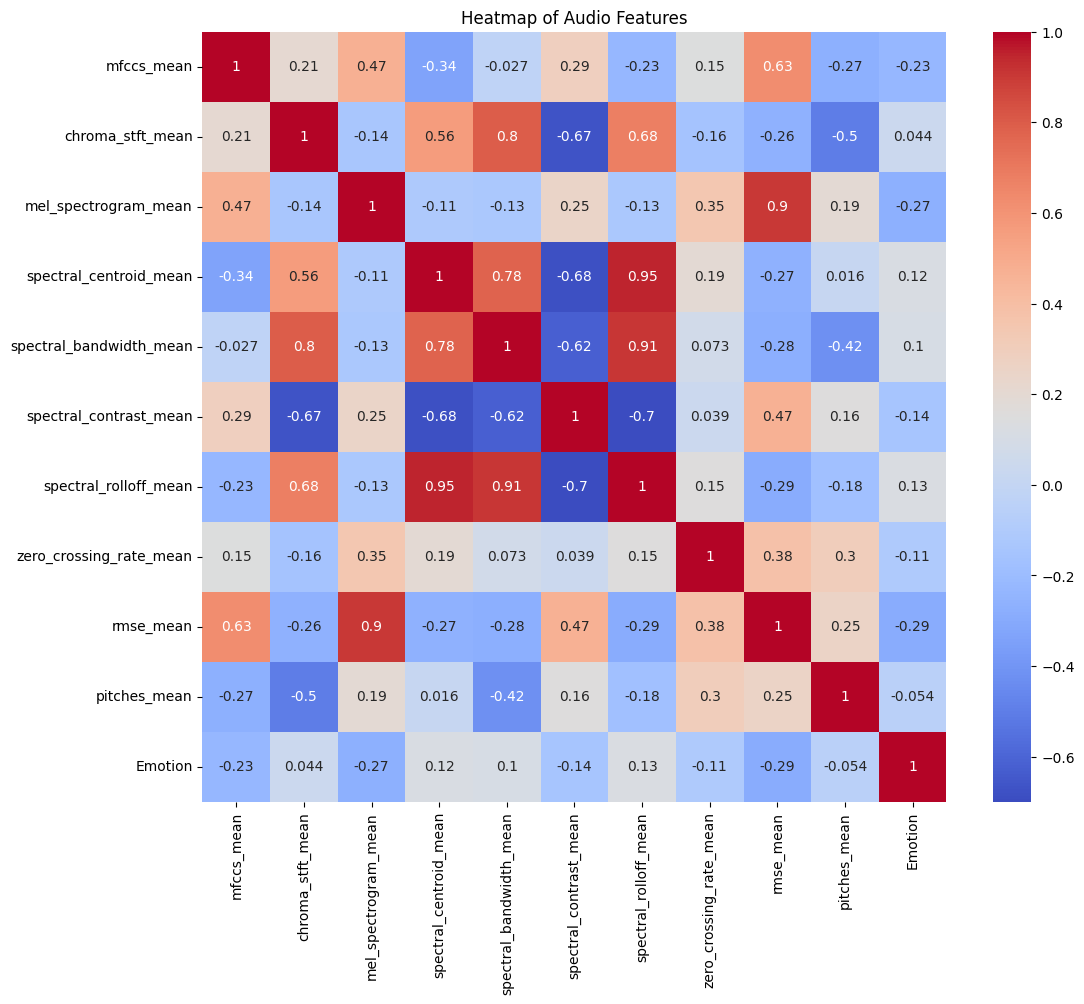

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import LabelEncoder

# Function to handle both lists and numeric values
def string_to_mean_list(value):
    try:
        # Try to convert the string representation of the list to an actual list
        list_of_values = ast.literal_eval(value)
        if isinstance(list_of_values, list):
            # Return the mean of the list
            return sum(list_of_values) / len(list_of_values)
        else:
            return value
    except (ValueError, SyntaxError):
        # If the value is already numeric, return it as is
        return value

# Read the CSV file
csv_file = 'audio_info_large.csv'
data = pd.read_csv(csv_file)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the emotions
data['Emotion'] = label_encoder.fit_transform(data['Emotion'])

# Select the feature columns
feature_columns = ['mfccs_mean', 'chroma_stft_mean', 'mel_spectrogram_mean', 
                   'spectral_centroid_mean', 'spectral_bandwidth_mean', 
                   'spectral_contrast_mean', 'spectral_rolloff_mean', 
                   'zero_crossing_rate_mean', 'rmse_mean', 'pitches_mean']

# Apply string_to_mean_list to each feature column
for col in feature_columns:
    data[col] = data[col].map(string_to_mean_list)

# Ensure all columns are numeric
for col in feature_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop rows with NaN values
data_clean = data.dropna(subset=feature_columns + ['Emotion'])

# Select the features and label
features = data_clean[feature_columns + ['Emotion']]

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(features.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Audio Features')
plt.show()

We have selected the features mfccs_mean, mel_spectrogram_mean, spectral_contrast_mean, rmse_mean, spectral_rolloff_mean, spectral_centroid_mean, and spectral_bandwidth_mean due to their correlation with emotion, as shown in the heatmap. These features exhibit significant (positive or negative) correlation values with emotion, which can help improve the performance of our emotion classification model.

In [48]:
# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)
# Display the first few rows of the DataFrame
df.head()

,Filename,Modality,Vocal Channel,Emotion,Emotional Intensity,Statement,Repetition,Actor,Gender,mfccs_mean,chroma_stft_mean,mel_spectrogram_mean,spectral_centroid_mean,spectral_bandwidth_mean,spectral_contrast_mean,spectral_rolloff_mean,zero_crossing_rate_mean,rmse_mean,pitches_mean
0,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,Surprised,Normal,Kids are talking by the door,1st,2,Female,"[-601.55707, 56.22707, -14.788618, 5.832394, -...","[0.41896352, 0.40761253, 0.37211162, 0.3533477...","[0.003825967, 0.0011404804, 0.00025742437, 0.0...",[4882.27424277],[4355.14836302],"[12.049979684663356, 12.943317994701323, 14.76...",[9593.56174699],[0.07735581],[0.00667724],1779.1371
1,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,Neutral,Normal,Kids are talking by the door,1st,2,Female,"[-675.8518, 68.959435, -4.962603, 5.4231396, 0...","[0.40752068, 0.37077308, 0.38555482, 0.4148727...","[2.31389e-05, 7.312122e-05, 0.00010316969, 9.8...",[4876.75482521],[4398.78064984],"[13.007164071660306, 13.099460464986109, 14.06...",[9352.45601173],[0.05509846],[0.00334483],1710.9099
2,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,Disgust,Strong,Kids are talking by the door,2nd,2,Female,"[-604.80096, 67.3899, -13.988149, 8.43896, -4....","[0.5164956, 0.4772493, 0.44307688, 0.45722714,...","[2.0692374e-05, 6.149694e-05, 0.00014364629, 0...",[5711.7822108],[4570.489909],"[11.619366704425428, 11.79519635666492, 12.678...",[10298.12338918],[0.06745203],[0.00570505],1830.7006
3,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,Disgust,Normal,Kids are talking by the door,2nd,2,Female,"[-676.8213, 79.52574, -12.700561, 8.421185, -1...","[0.35767305, 0.30192342, 0.2898281, 0.33913195...","[5.167476e-06, 2.5261925e-05, 0.00011202514, 0...",[3880.66164716],[3724.37979845],"[14.58326248839438, 11.754292086026478, 12.780...",[7629.97159091],[0.05931114],[0.00285519],1806.4209
4,/kaggle/input/emotion-classification-speach/sp...,Audio-Only,Speech,Neutral,Normal,Dogs are sitting by the door,1st,2,Female,"[-640.2968, 64.62258, -5.608734, 3.477043, -2....","[0.4563617, 0.45719966, 0.5027275, 0.507411, 0...","[3.1358548e-05, 0.00011655276, 0.00013609538, ...",[6271.87998856],[5041.19681367],"[10.721483173288489, 12.288058024237833, 13.54...",[11341.43273305],[0.06424623],[0.00512985],1737.8857


In [49]:
df.columns

Index(['Filename', 'Modality', 'Vocal Channel', 'Emotion',
       'Emotional Intensity', 'Statement', 'Repetition', 'Actor', 'Gender',
       'mfccs_mean', 'chroma_stft_mean', 'mel_spectrogram_mean',
       'spectral_centroid_mean', 'spectral_bandwidth_mean',
       'spectral_contrast_mean', 'spectral_rolloff_mean',
       'zero_crossing_rate_mean', 'rmse_mean', 'pitches_mean'],
      dtype='object')

In [50]:
df=df.drop(columns=['chroma_stft_mean','spectral_centroid_mean', 'spectral_bandwidth_mean',
       'spectral_contrast_mean', 'spectral_rolloff_mean',
       'zero_crossing_rate_mean','pitches_mean'], axis=1)

In [51]:
df=df.drop(columns=['Filename','Modality','Vocal Channel',
       'Emotional Intensity', 'Statement', 'Repetition', 'Actor', 'Gender'], axis=1)

In [52]:
df.columns

Index(['Emotion', 'mfccs_mean', 'mel_spectrogram_mean', 'rmse_mean'], dtype='object')

In [53]:
df.head()
data=df

In [54]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def safe_str_to_array(x):
    if isinstance(x, str):
        # Remove square brackets and split the string
        try:
            return np.fromstring(x.strip('[]'), sep=',')
        except ValueError:
            print(f"ValueError: Could not parse {x}")
            return np.array([])
    else:
        # Return empty array for NaN or unexpected data
        return np.array([])

# Apply the function to convert each column
data['mfccs_mean'] = data['mfccs_mean'].apply(safe_str_to_array)
# data['chroma_stft_mean'] = data['chroma_stft_mean'].apply(safe_str_to_array)
data['mel_spectrogram_mean'] = data['mel_spectrogram_mean'].apply(safe_str_to_array)
# data['spectral_centroid_mean'] = data['spectral_centroid_mean'].apply(safe_str_to_array)
# data['spectral_bandwidth_mean'] = data['spectral_bandwidth_mean'].apply(safe_str_to_array)
# data['spectral_contrast_mean'] = data['spectral_contrast_mean'].apply(safe_str_to_array)
# data['spectral_rolloff_mean'] = data['spectral_rolloff_mean'].apply(safe_str_to_array)
# data['zero_crossing_rate_mean'] = data['zero_crossing_rate_mean'].apply(safe_str_to_array)
data['rmse_mean'] = data['rmse_mean'].apply(safe_str_to_array)
# data['pitches_mean'] = data['pitches_mean'].apply(safe_str_to_array)
# 
# Check conversion
print(data['mfccs_mean'].head())

# Handle empty arrays or incomplete data
# For simplicity, fill NaNs or empty data with zeros or the mean value of the column
data['mfccs_mean'] = data['mfccs_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
# data['chroma_stft_mean'] = data['chroma_stft_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
data['mel_spectrogram_mean'] = data['mel_spectrogram_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
# data['spectral_centroid_mean'] = data['spectral_centroid_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
# data['spectral_bandwidth_mean'] = data['spectral_bandwidth_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
# data['spectral_contrast_mean'] = data['spectral_contrast_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
# data['spectral_rolloff_mean'] = data['spectral_rolloff_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
# data['zero_crossing_rate_mean'] = data['zero_crossing_rate_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
data['rmse_mean'] = data['rmse_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
# data['pitches_mean'] = data['pitches_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

# Prepare the features and labels
X = data.drop(columns=['Emotion'])  # Features only
y = data['Emotion']  # Labels

# Normalize the features (only numeric ones)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Reshape features to match CNN input shape (assuming we want a 2D shape)
# Here we reshape to (number of samples, height, width, channels)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

0    [-601.55707, 56.22707, -14.788618, 5.832394, -...
1    [-675.8518, 68.959435, -4.962603, 5.4231396, 0...
2    [-604.80096, 67.3899, -13.988149, 8.43896, -4....
3    [-676.8213, 79.52574, -12.700561, 8.421185, -1...
4    [-640.2968, 64.62258, -5.608734, 3.477043, -2....
Name: mfccs_mean, dtype: object


In [55]:
# Define input shape and number of classes
input_shape = (X_train.shape[1], 1, 1)  # (features, 1, 1)
num_classes = len(np.unique(y_train))

def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # Convolutional Block 1
    model.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    
    # Convolutional Block 2
    model.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Convolutional Block 3
    model.add(Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    
    # Convolutional Block 4
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Convolutional Block 5
    model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=3, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Create the model
model_n_aug_ex_feat = create_cnn_model(input_shape, num_classes)

# Compile the model
model_n_aug_ex_feat.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_n_aug_ex_feat.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 3, 1, 128)      │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 3, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 2, 1, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 2, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 1, 1, 64)       │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 1, 1, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 1, 1, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 1, 1, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         1,03

 Total params: 680,744 (2.60 MB)

 Trainable params: 679,656 (2.59 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [56]:
# Train the model
history_n_aug_ex_feat = model_n_aug_ex_feat.fit(X_train_reshaped, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.1778 - loss: 2.3322 - val_accuracy: 0.1705 - val_loss: 2.0478
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2220 - loss: 2.0807 - val_accuracy: 0.1705 - val_loss: 2.0398
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2362 - loss: 1.9871 - val_accuracy: 0.1450 - val_loss: 2.0263
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2575 - loss: 1.9033 - val_accuracy: 0.1450 - val_loss: 2.0243
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2643 - loss: 1.8649 - val_accuracy: 0.1476 - val_loss: 1.9792
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2665 - loss: 1.8548 - val_accuracy: 0.1476 - val_loss: 1.9869
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2860 - loss: 1.8419 - val_accuracy: 0.1832 - val_loss: 2.0052
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2701 - loss: 1.8346 - val_accuracy: 0.1807 - val_los

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


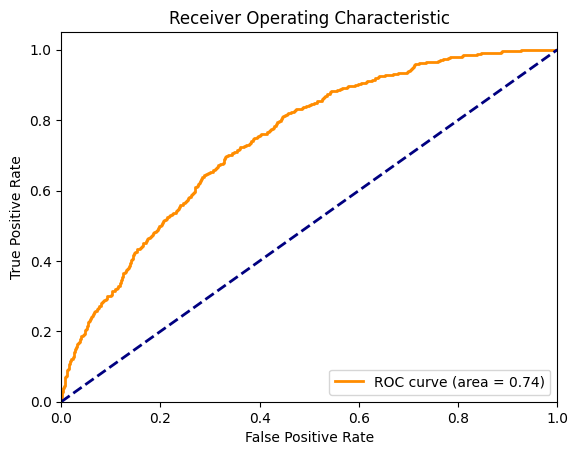

Accuracy: 0.31
Precision: 0.30
Recall: 0.31
F1-score: 0.30
AUC: 0.74


In [58]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Make predictions on the test set
y_pred = model_n_aug_ex_feat.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# AUC and ROC
y_test_bin = to_categorical(y_test, num_classes)
y_pred_prob = y_pred  # Model's output probabilities

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC: {roc_auc["micro"]:.2f}')

### **Confusion Matrix**

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


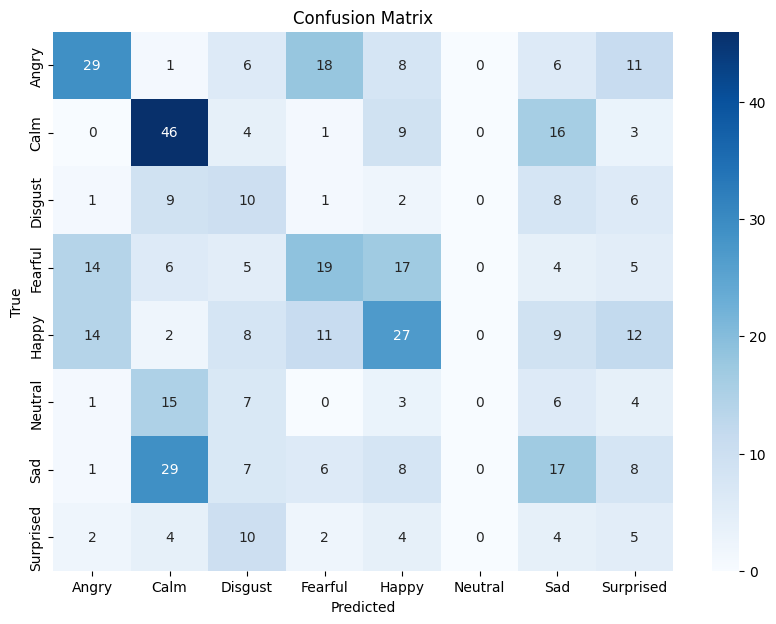

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = model_n_aug_ex_feat.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Extracted Features for **augmented data**:

In [60]:
import os
import csv
import librosa
import numpy as np

# Function to extract information from the filename
def extract_info(filename):
    # Split the filename to extract different parts
    parts = filename.split('.')[0].split('-')
    info = {
        'Modality': parts[0],
        'Vocal Channel': parts[1],
        'Emotion': parts[2],
        'Emotional Intensity': parts[3],
        'Statement': parts[4],
        'Repetition': parts[5],
        'Actor': parts[6],
    }
    return info

# Function to extract audio features
def extract_audio_features(filepath):
    y, sr = librosa.load(filepath, sr=None)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
    rmse = np.mean(librosa.feature.rms(y=y).T, axis=0)
    pitches, _ = librosa.piptrack(y=y, sr=sr)
    pitches_mean = np.mean(pitches[pitches > 0])
    
    return (mfccs, chroma, mel, spectral_centroid, spectral_bandwidth, 
            spectral_contrast, spectral_rolloff, zero_crossing_rate, rmse, pitches_mean)

# Directory containing the RAVDESS files
directory = '/kaggle/working/augmented_data'

# Create a CSV file to store the extracted information
csv_file = 'audio_info_large_augmented_data.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row in the CSV file
    writer.writerow(['Filename', 'Modality', 'Vocal Channel', 'Emotion', 'Emotional Intensity', 'Statement', 'Repetition', 'Actor', 'Gender', 
                     'mfccs_mean', 'chroma_stft_mean', 'mel_spectrogram_mean', 'spectral_centroid_mean', 
                     'spectral_bandwidth_mean', 'spectral_contrast_mean', 'spectral_rolloff_mean', 
                     'zero_crossing_rate_mean', 'rmse_mean', 'pitches_mean'])

    # Traverse through the directory and its subdirectories
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.wav'):
                # Construct the full file path
                filepath = os.path.join(dirname, filename)
                # Extract information from the filename
                info = extract_info(filename)
                
                # Map numerical codes to their respective labels
                modality = 'Full-AV' if info['Modality'] == '01' else 'Video-Only' if info['Modality'] == '02' else 'Audio-Only'
                vocal_channel = 'Speech' if info['Vocal Channel'] == '01' else 'Song'
                emotion_dict = {
                    '01': 'Neutral',
                    '02': 'Calm',
                    '03': 'Happy',
                    '04': 'Sad',
                    '05': 'Angry',
                    '06': 'Fearful',
                    '07': 'Disgust',
                    '08': 'Surprised'
                }
                emotion = emotion_dict[info['Emotion']]
                intensity = 'Normal' if info['Emotional Intensity'] == '01' else 'Strong'
                statement = 'Kids are talking by the door' if info['Statement'] == '01' else 'Dogs are sitting by the door'
                repetition = '1st' if info['Repetition'] == '01' else '2nd'
                actor = info['Actor']
                gender = 'Male' if int(actor) % 2 != 0 else 'Female'
                
                # Extract audio features
                mfccs, chroma, mel, spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff, zero_crossing_rate, rmse, pitches_mean = extract_audio_features(filepath)

                # Write the extracted information to the CSV file
                writer.writerow([filepath, modality, vocal_channel, emotion, intensity, statement, repetition, actor, gender, 
                                 list(mfccs), list(chroma), list(mel), spectral_centroid, spectral_bandwidth, 
                                 list(spectral_contrast), spectral_rolloff, zero_crossing_rate, rmse, pitches_mean])

#### Correlation Matrix of Augmented Audio Features for Emotion Classification

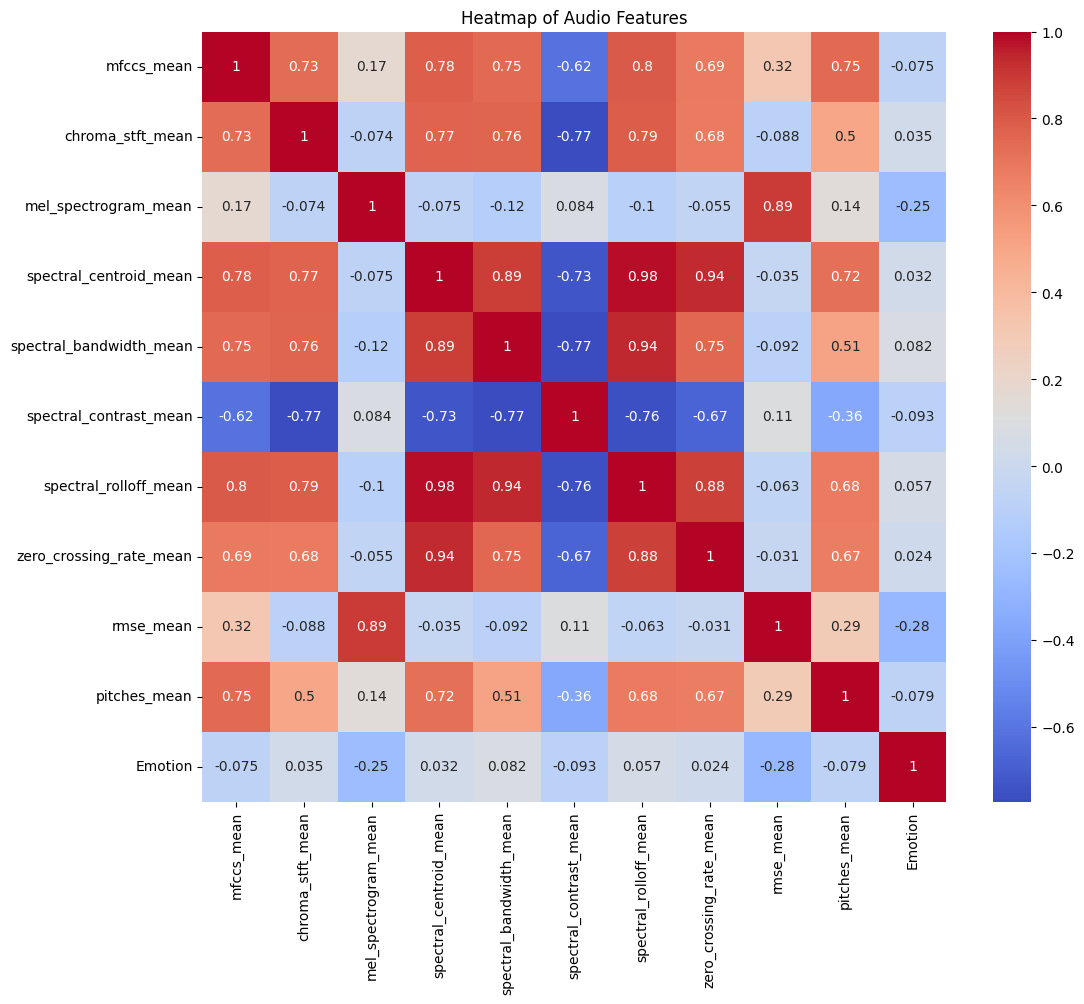

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import LabelEncoder

# Function to handle both lists and numeric values
def string_to_mean_list(value):
    try:
        # Try to convert the string representation of the list to an actual list
        list_of_values = ast.literal_eval(value)
        if isinstance(list_of_values, list):
            # Return the mean of the list
            return sum(list_of_values) / len(list_of_values)
        else:
            return value
    except (ValueError, SyntaxError):
        # If the value is already numeric, return it as is
        return value

# Read the CSV file
csv_file = '/kaggle/working/audio_info_large_augmented_data.csv'
data = pd.read_csv(csv_file)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the emotions
data['Emotion'] = label_encoder.fit_transform(data['Emotion'])

# Select the feature columns
feature_columns = ['mfccs_mean', 'chroma_stft_mean', 'mel_spectrogram_mean', 
                   'spectral_centroid_mean', 'spectral_bandwidth_mean', 
                   'spectral_contrast_mean', 'spectral_rolloff_mean', 
                   'zero_crossing_rate_mean', 'rmse_mean', 'pitches_mean']

# Apply string_to_mean_list to each feature column
for col in feature_columns:
    data[col] = data[col].map(string_to_mean_list)

# Ensure all columns are numeric
for col in feature_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop rows with NaN values
data_clean = data.dropna(subset=feature_columns + ['Emotion'])

# Select the features and label
features = data_clean[feature_columns + ['Emotion']]

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(features.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Audio Features')
plt.show()

In [62]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/working/audio_info_large_augmented_data.csv')
# Display the first few rows of the DataFrame
df.head()

,Filename,Modality,Vocal Channel,Emotion,Emotional Intensity,Statement,Repetition,Actor,Gender,mfccs_mean,chroma_stft_mean,mel_spectrogram_mean,spectral_centroid_mean,spectral_bandwidth_mean,spectral_contrast_mean,spectral_rolloff_mean,zero_crossing_rate_mean,rmse_mean,pitches_mean
0,/kaggle/working/augmented_data/03-01-07-01-02-...,Audio-Only,Speech,Disgust,Normal,Dogs are sitting by the door,2nd,13,Male,"[-728.4608, 64.43513, 6.500011, 10.830953, -0....","[0.59143835, 0.62324, 0.65548474, 0.6012447, 0...","[1.2719e-05, 5.9448544e-06, 2.807378e-05, 0.00...",[3402.54310919],[2824.66362676],"[20.304918447455005, 12.874192430482175, 14.53...",[6645.06958008],[0.16507394],[0.00140201],1114.3989
1,/kaggle/working/augmented_data/03-02-06-01-02-...,Audio-Only,Song,Fearful,Normal,Dogs are sitting by the door,2nd,23,Male,"[-489.75394, 53.394203, -15.177028, 6.0070934,...","[0.3476454, 0.28526214, 0.3060718, 0.44392413,...","[7.5881515e-05, 9.613191e-05, 0.000115843606, ...",[3127.75767373],[2588.84722501],"[24.71635350853244, 17.563434398100622, 19.276...",[5743.3423335],[0.27023708],[0.01671837],1577.7954
2,/kaggle/working/augmented_data/03-01-05-02-01-...,Audio-Only,Speech,Angry,Strong,Kids are talking by the door,1st,23,Male,"[-456.337, 21.949965, -20.253494, -1.9425161, ...","[0.48397905, 0.4799635, 0.47601542, 0.5007777,...","[0.009674967, 0.0039264695, 0.0014892255, 0.00...",[3500.68517167],[2824.44556766],"[16.439919762660168, 16.289028184616296, 17.65...",[6789.69726562],[0.20953577],[0.02529958],1504.7352
3,/kaggle/working/augmented_data/03-01-08-01-01-...,Audio-Only,Speech,Surprised,Normal,Kids are talking by the door,1st,17,Male,"[-560.1946, 43.547802, -1.8486894, 7.7822824, ...","[0.5739701, 0.61637896, 0.5792289, 0.5594958, ...","[0.043927442, 0.0009773717, 0.0017048344, 0.02...",[3099.86027156],[3016.95491528],"[19.49225785633489, 13.681661111913282, 15.649...",[6687.37792969],[0.17385138],[0.00858038],1674.1929
4,/kaggle/working/augmented_data/03-01-08-02-01-...,Audio-Only,Speech,Surprised,Strong,Kids are talking by the door,1st,17,Male,"[-285.92004, 13.031654, 4.2276635, 5.8913064, ...","[0.6008465, 0.65691036, 0.69855917, 0.7119562,...","[0.31914127, 0.012662421, 0.0035561817, 0.0040...",[4720.47988621],[3197.50888107],"[14.520101658424988, 13.165214300387674, 13.65...",[8690.96966912],[0.35532514],[0.01594769],2029.0355


In [63]:
df.columns

Index(['Filename', 'Modality', 'Vocal Channel', 'Emotion',
       'Emotional Intensity', 'Statement', 'Repetition', 'Actor', 'Gender',
       'mfccs_mean', 'chroma_stft_mean', 'mel_spectrogram_mean',
       'spectral_centroid_mean', 'spectral_bandwidth_mean',
       'spectral_contrast_mean', 'spectral_rolloff_mean',
       'zero_crossing_rate_mean', 'rmse_mean', 'pitches_mean'],
      dtype='object')

In [64]:
df=df.drop(columns=['Filename','Modality','Vocal Channel',
       'Emotional Intensity', 'Statement', 'Repetition', 'Actor', 'Gender'], axis=1)

In [65]:
data=df

In [66]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

def safe_str_to_array(x):
    if isinstance(x, str):
        # Remove square brackets and split the string
        try:
            return np.fromstring(x.strip('[]'), sep=',')
        except ValueError:
            print(f"ValueError: Could not parse {x}")
            return np.array([])
    else:
        # Return empty array for NaN or unexpected data
        return np.array([])

# Apply the function to convert each column
data['mfccs_mean'] = data['mfccs_mean'].apply(safe_str_to_array)
data['chroma_stft_mean'] = data['chroma_stft_mean'].apply(safe_str_to_array)
data['mel_spectrogram_mean'] = data['mel_spectrogram_mean'].apply(safe_str_to_array)
data['spectral_centroid_mean'] = data['spectral_centroid_mean'].apply(safe_str_to_array)
data['spectral_bandwidth_mean'] = data['spectral_bandwidth_mean'].apply(safe_str_to_array)
data['spectral_contrast_mean'] = data['spectral_contrast_mean'].apply(safe_str_to_array)
data['spectral_rolloff_mean'] = data['spectral_rolloff_mean'].apply(safe_str_to_array)
data['zero_crossing_rate_mean'] = data['zero_crossing_rate_mean'].apply(safe_str_to_array)
data['rmse_mean'] = data['rmse_mean'].apply(safe_str_to_array)
data['pitches_mean'] = data['pitches_mean'].apply(safe_str_to_array)
# 
# Check conversion
print(data['mfccs_mean'].head())

# Handle empty arrays or incomplete data
# For simplicity, fill NaNs or empty data with zeros or the mean value of the column
data['mfccs_mean'] = data['mfccs_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
data['chroma_stft_mean'] = data['chroma_stft_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
data['mel_spectrogram_mean'] = data['mel_spectrogram_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
# data['spectral_centroid_mean'] = data['spectral_centroid_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
data['spectral_bandwidth_mean'] = data['spectral_bandwidth_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
data['spectral_contrast_mean'] = data['spectral_contrast_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
data['spectral_rolloff_mean'] = data['spectral_rolloff_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
data['zero_crossing_rate_mean'] = data['zero_crossing_rate_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
data['rmse_mean'] = data['rmse_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
data['pitches_mean'] = data['pitches_mean'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

# Prepare the features and labels
X = data.drop(columns=['Emotion'])  # Features only
y = data['Emotion']  # Labels

# Normalize the features (only numeric ones)
mmscaler = MinMaxScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Reshape features to match CNN input shape (assuming we want a 2D shape)
# Here we reshape to (number of samples, height, width, channels)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

0    [-728.4608, 64.43513, 6.500011, 10.830953, -0....
1    [-489.75394, 53.394203, -15.177028, 6.0070934,...
2    [-456.337, 21.949965, -20.253494, -1.9425161, ...
3    [-560.1946, 43.547802, -1.8486894, 7.7822824, ...
4    [-285.92004, 13.031654, 4.2276635, 5.8913064, ...
Name: mfccs_mean, dtype: object


In [67]:
# Define input shape and number of classes
input_shape = (X_train.shape[1], 1, 1)  # (features, 1, 1)
num_classes = len(np.unique(y_train))

def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # Convolutional Block 0
    model.add(Conv2D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    
    # Convolutional Block 1
    model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    
    # Convolutional Block 2
    model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Convolutional Block 3
    model.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    
    # Convolutional Block 4
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Convolutional Block 5
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=3, strides=2, padding='same'))
    model.add(Dropout(0.2))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Create the model
model_aug_ex_feat = create_cnn_model(input_shape, num_classes)

# Compile the model
model_aug_ex_feat.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_aug_ex_feat.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 10, 1, 512)     │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 10, 1, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 5, 1, 256)      │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 5, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 3, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 3, 1, 256)      │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 3, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 2, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 2, 1, 128)      │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 2, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 1, 1, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 1, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             

 Total params: 5,994,824 (22.87 MB)

 Trainable params: 5,991,624 (22.86 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [68]:
# Train the model
history_aug_ex_feat = model_aug_ex_feat.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.1838 - loss: 2.3090 - val_accuracy: 0.1459 - val_loss: 2.2825
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2505 - loss: 1.9071 - val_accuracy: 0.1497 - val_loss: 2.5227
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2562 - loss: 1.8549 - val_accuracy: 0.1924 - val_loss: 2.1282
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2925 - loss: 1.7672 - val_accuracy: 0.3000 - val_loss: 1.7346
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2911 - loss: 1.7507 - val_accuracy: 0.2968 - val_loss: 1.7096
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2915 - loss: 1.7559 - val_accuracy: 0.3006 - val_loss: 1.7876
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3007 - loss: 1.7136 - val_accuracy: 0.3217 - val_loss: 1.6477
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3053 - loss: 1.6936 - val_accuracy: 

## **Metrics**

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


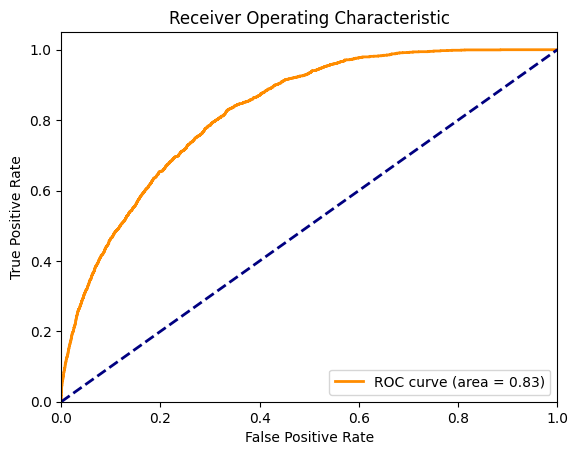

Accuracy: 0.39
Precision: 0.40
Recall: 0.39
F1-score: 0.38
AUC: 0.83


In [69]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Make predictions on the test set
y_pred = model_aug_ex_feat.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# AUC and ROC
y_test_bin = to_categorical(y_test, num_classes)
y_pred_prob = y_pred  # Model's output probabilities

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC: {roc_auc["micro"]:.2f}')

### **Confusion Matrix**

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


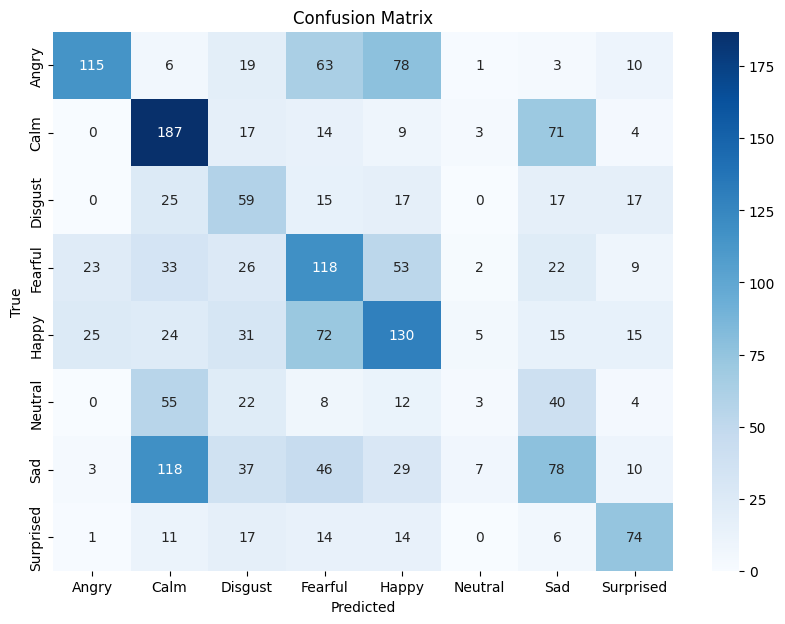

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = model_aug_ex_feat.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()